In [29]:
import pandas as pd
df = pd.read_parquet('df_final.parquet')

In [30]:
df.shape

(60385, 32)

In [31]:
df.head()

,season_id,team_id_home,game_id,game_date,min,fgm_home,ftm_home,fta_home,ft_pct_home,pf_home,...,Winner,Loser,winner_elo_pre,loser_elo_pre,elo_diff,winner_elo_surf_pre,loser_elo_surf_pre,elo_surf_diff,h2h_pre,recent_form_diff
0,21946,1610610034,24600012,1946-11-07,0,25.0,13.0,20.0,0.650,21.0,...,1610612752,1610610034,1000.0,1000.000000,0.000000,1000.0,1000.000000,0.000000,0,0
1,21946,1610612744,24600010,1946-11-07,0,28.0,25.0,39.0,0.641,24.0,...,1610612744,1610610031,1000.0,1000.000000,0.000000,1000.0,1000.000000,0.000000,0,0
2,21946,1610610035,24600013,1946-11-08,0,31.0,11.0,26.0,0.423,21.0,...,1610610035,1610610028,1000.0,1000.000000,0.000000,1000.0,1000.000000,0.000000,0,0
3,21946,1610610031,24600019,1946-11-11,0,29.0,26.0,35.0,0.743,32.0,...,1610610031,1610610032,984.0,1000.000000,-16.000000,984.0,1000.000000,-16.000000,0,0
4,21946,1610610035,24600025,1946-11-15,0,32.0,21.0,28.0,0.750,22.0,...,1610610035,1610610032,1016.0,983.263693,32.736307,1016.0,983.263693,32.736307,0,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60385 entries, 0 to 60384
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   season_id             60385 non-null  int64         
 1   team_id_home          60385 non-null  int64         
 2   game_id               60385 non-null  int64         
 3   game_date             60385 non-null  datetime64[ns]
 4   min                   60385 non-null  int64         
 5   fgm_home              60385 non-null  float64       
 6   ftm_home              60385 non-null  float64       
 7   fta_home              60385 non-null  float64       
 8   ft_pct_home           60385 non-null  float64       
 9   pf_home               60385 non-null  float64       
 10  pts_home              60385 non-null  float64       
 11  plus_minus_home       60385 non-null  int64         
 12  video_available_home  60385 non-null  int64         
 13  team_id_away    

In [33]:
cutoff_date = "2020-01-01"
begin_date = "2016-01-01"
train = df[(df["game_date"] < cutoff_date) & (df["game_date"] >= begin_date)]
test = df[df["game_date"] >= cutoff_date]

In [34]:
def make_training_rows(df):
    rows = []
    for _, row in df.iterrows():
        w, l = row["Winner"], row["Loser"]

        # features
        w_feats = {
            "elo_diff": row["winner_elo_pre"] - row["loser_elo_pre"],
            "elo_surf_diff": row["winner_elo_surf_pre"] - row["loser_elo_surf_pre"],
            "h2h_pre": row["h2h_pre"],
            "recent_form_diff": row["recent_form_diff"],
            "label": 1  # winner perspective
        }
        l_feats = {
            "elo_diff": row["loser_elo_pre"] - row["winner_elo_pre"],
            "elo_surf_diff": row["loser_elo_surf_pre"] - row["winner_elo_surf_pre"],
            "h2h_pre": -row["h2h_pre"],  # flip perspective
            "recent_form_diff": -row["recent_form_diff"],
            "label": 0  # loser perspective
        }

        rows.append(w_feats)
        rows.append(l_feats)

    return pd.DataFrame(rows)

In [35]:
train_data = make_training_rows(train)
test_data = make_training_rows(test)

X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]

X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

print(y_train.value_counts())  # should now show both 0 and 1

label
1    5450
0    5450
Name: count, dtype: int64


In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Linear Models

In [37]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6126730103806228
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.61      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.613538062283737
              precision    recall  f1-score   support

           0       0.60      0.68      0.64      4624
           1       0.63      0.55      0.59      4624

    accuracy                           0.61      9248
   macro avg       0.62      0.61      0.61      9248
weighted avg       0.62      0.61      0.61      9248



In [39]:
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6126730103806228
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.61      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



In [40]:
from sklearn.linear_model import Perceptron

model = Perceptron(tol=1e-3, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.38538062283737023
              precision    recall  f1-score   support

           0       0.39      0.39      0.39      4624
           1       0.39      0.39      0.39      4624

    accuracy                           0.39      9248
   macro avg       0.39      0.39      0.39      9248
weighted avg       0.39      0.39      0.39      9248



# Support Vector Machines

In [41]:
from sklearn.svm import LinearSVC

model = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6126730103806228
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.61      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



# Tree Based

In [42]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5367647058823529
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      4624
           1       0.54      0.54      0.54      4624

    accuracy                           0.54      9248
   macro avg       0.54      0.54      0.54      9248
weighted avg       0.54      0.54      0.54      9248



In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier

extra_tree = ExtraTreeClassifier(random_state=0)
model = BaggingClassifier(extra_tree, random_state=0).fit(
   X_train, y_train)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5618512110726643
              precision    recall  f1-score   support

           0       0.55      0.63      0.59      4624
           1       0.57      0.50      0.53      4624

    accuracy                           0.56      9248
   macro avg       0.56      0.56      0.56      9248
weighted avg       0.56      0.56      0.56      9248



In [44]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6151600346020761
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      4624
           1       0.61      0.62      0.62      4624

    accuracy                           0.62      9248
   macro avg       0.62      0.62      0.62      9248
weighted avg       0.62      0.62      0.62      9248



In [45]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.615916955017301
              precision    recall  f1-score   support

           0       0.62      0.59      0.61      4624
           1       0.61      0.64      0.62      4624

    accuracy                           0.62      9248
   macro avg       0.62      0.62      0.62      9248
weighted avg       0.62      0.62      0.62      9248



# Nearest Neighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5741782006920415
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      4624
           1       0.57      0.57      0.57      4624

    accuracy                           0.57      9248
   macro avg       0.57      0.57      0.57      9248
weighted avg       0.57      0.57      0.57      9248



# Naive Bayes

In [47]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6068339100346021
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.61      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



In [48]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6133217993079585
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.61      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



# LightGBM

In [49]:
import lightgbm as lgb
model = lgb.LGBMClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 5450, number of negative: 5450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 10900, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.6078070934256056
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.60      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



# Discriminant Analysis

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6126730103806228
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.61      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



In [51]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.613538062283737
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.61      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



/home/souparno/Documents/basketball_prediction/basketball-env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/souparno/Documents/basketball_prediction/basketball-env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


# XGBoost

In [52]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.05, eval_metric="logloss"
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6115916955017301
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4624
           1       0.61      0.62      0.61      4624

    accuracy                           0.61      9248
   macro avg       0.61      0.61      0.61      9248
weighted avg       0.61      0.61      0.61      9248



# Neural Network

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Assume your data is already loaded and split as in your prompt
# X_train, y_train, X_test, y_test

# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int64) # Use int64 for CrossEntropyLoss

X_test_np = X_test.values.astype(np.float32)
y_test_np = y_test.values.astype(np.int64)

# Create a custom PyTorch Dataset
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset and DataLoader instances
train_dataset = TabularDataset(X_train_np, y_train_np)
test_dataset = TabularDataset(X_test_np, y_test_np)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define number of input features and classes
input_dim = X_train.shape[1]
output_dim = len(y_train.value_counts())

In [54]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2//2),
            nn.ReLU(),
            nn.Linear(hidden_dim2//2, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Model, Loss, and Optimizer
model_mlp = MLP(input_dim=input_dim, hidden_dim1=256, hidden_dim2=64, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model_mlp.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluation
model_mlp.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_mlp(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Accuracy of MLP on test data: {100 * correct / total:.2f}%")

Epoch 1/20, Loss: 0.7091
Epoch 2/20, Loss: 0.6409
Epoch 3/20, Loss: 0.5538
Epoch 4/20, Loss: 0.5986
Epoch 5/20, Loss: 0.5997
Epoch 6/20, Loss: 0.6394
Epoch 7/20, Loss: 0.6483
Epoch 8/20, Loss: 0.6849
Epoch 9/20, Loss: 0.6831
Epoch 10/20, Loss: 0.6809
Epoch 11/20, Loss: 0.7006
Epoch 12/20, Loss: 0.6889
Epoch 13/20, Loss: 0.7387
Epoch 14/20, Loss: 0.7367
Epoch 15/20, Loss: 0.6215
Epoch 16/20, Loss: 0.6565
Epoch 17/20, Loss: 0.5760
Epoch 18/20, Loss: 0.5203
Epoch 19/20, Loss: 0.6350
Epoch 20/20, Loss: 0.6198
Accuracy of MLP on test data: 61.46%


In [55]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6150519031141869
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      4624
           1       0.61      0.62      0.62      4624

    accuracy                           0.62      9248
   macro avg       0.62      0.62      0.62      9248
weighted avg       0.62      0.62      0.62      9248



In [56]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(
    estimators=[
        ('logreg', LogisticRegression()),
        ('gbc', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)),
        ('mlp', MLPClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression()  # meta-learner
)
stack.fit(X_train, y_train)
print("Stacking accuracy:", stack.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Stacking accuracy: 0.6161332179930796
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      4624
           1       0.61      0.62      0.62      4624

    accuracy                           0.62      9248
   macro avg       0.62      0.62      0.62      9248
weighted avg       0.62      0.62      0.62      9248



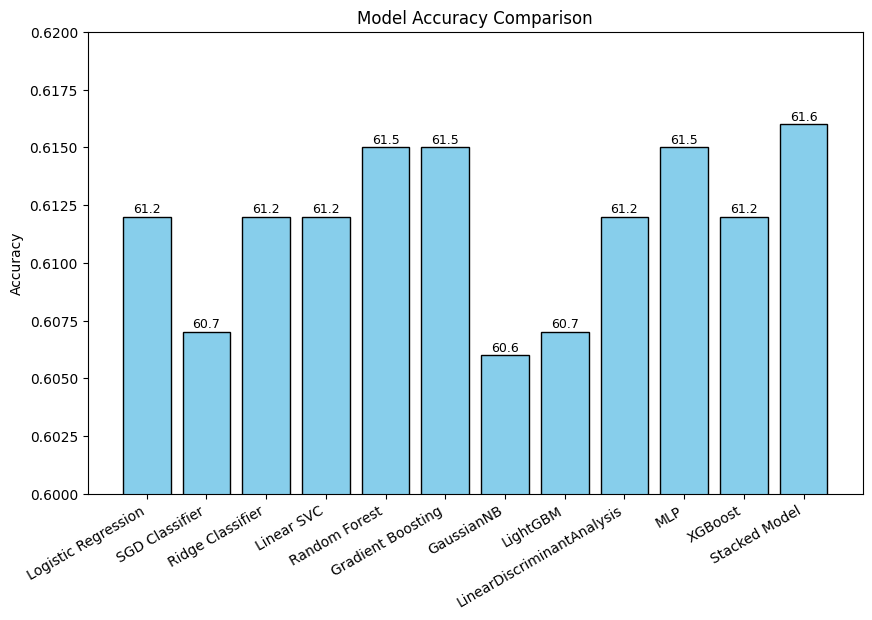

In [75]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'SGD Classifier', 'Ridge Classifier', 'Linear SVC', 'Random Forest', 'Gradient Boosting', 'GaussianNB', 'LightGBM', 'LinearDiscriminantAnalysis', 'MLP', 'XGBoost', 'Stacked Model']
accuracies = [0.612, 0.607, 0.612, 0.612, 0.615, 0.615, 0.606, 0.607, 0.612, 0.615, 0.612, 0.616]

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(models, accuracies, color="skyblue", edgecolor="black")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=30, ha="right")
plt.ylim(0.6, 0.62)  # since accuracy is between 0 and 1

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 0.00005,   # slightly above bar
             f"{acc*100:.1f}", 
             ha="center", va="bottom", fontsize=9)

plt.show()